Very short, simple and efficient way of predicting values with time series without using any features

In [1]:
#Import libs
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

Get the data

In [2]:
df = pd.read_csv("/kaggle/input/iyzico-datathon/train.csv")
res = pd.read_csv("/kaggle/input/iyzico-datathon/sample_submission.csv")

Find the last values and merge them with res

In [3]:
res[['month_id', 'merchant_id']] = res['id'].str.extract(r'(\d{6})(merchant_\d+)')

# Sort the DataFrame by 'merchant_id' and 'month_id' in descending order
df_sorted = df.sort_values(by=['merchant_id', 'month_id'], ascending=[True, False])

# Group by 'merchant_id' and keep the first row of each group
latest_data = df_sorted.groupby('merchant_id').first().reset_index()

result = pd.merge(res, latest_data, on='merchant_id', how='left')

Filters that can be optimized

In [4]:
# Ignoring small values and churned customers
result.loc[(result['net_payment_count_y'] < 5) | (result['month_id_y'] < 202309), 'net_payment_count_x'] = 0
# Get the latest data for baseline
result.loc[~((result['net_payment_count_y'] < 5) | (result['month_id_y'] < 202309)), 'net_payment_count_x'] = result['net_payment_count_y']

In [5]:
ids= result[result['net_payment_count_x']!=0]['merchant_id'].unique()
df['month_id'] = pd.to_datetime(df['month_id'], format='%Y%m')
df.set_index('month_id', inplace=True)

Training ARIMA models for the merchants one by one

In [6]:
from numpy.linalg import LinAlgError

for id in tqdm(ids):
  df_t = df[df['merchant_id'] == id]
  # Check if there is sufficient data to fit the model
  if len(df_t) > 3:
    try:
      model = ARIMA(df_t['net_payment_count'], order=(1, 1, 1))
      model_fit = model.fit()
      forecast_result = model_fit.get_forecast(steps=3)
      forecast = forecast_result.predicted_mean
      filtered_res = result[result['merchant_id']==id].sort_values(by='month_id_x')['net_payment_count_x']
      result.loc[filtered_res.index[:3], 'net_payment_count_x'] = list(forecast)
    except LinAlgError:
        print(f"Linear algebra error for merchant_id {id}")
    except Exception as e:
        print(f"Error fitting model for merchant_id {id}: {e}")


100%|██████████| 4383/4383 [04:17<00:00, 17.00it/s]


In [7]:
columns_to_keep = ['id', 'net_payment_count_x']
result = result[columns_to_keep]

# Rename 'net_payment_count_x' to 'net_payment_count'
result = result.rename(columns={'net_payment_count_x': 'net_payment_count'})

result

,id,net_payment_count
0,202311merchant_36004,0.0
1,202312merchant_36004,0.0
2,202310merchant_36004,0.0
3,202311merchant_23099,0.0
4,202312merchant_23099,0.0
...,...,...
78175,202312merchant_35969,0.0
78176,202310merchant_35969,0.0
78177,202311merchant_8429,0.0
78178,202312merchant_8429,0.0


Here, ready submission file

In [8]:
# Save to CSV to submit
result.to_csv('submitMe.csv', index=False)

**Visualization of some example for better understanding**

In [9]:
df = pd.read_csv("/kaggle/input/iyzico-datathon/train.csv")
res = pd.read_csv("/kaggle/input/iyzico-datathon/sample_submission.csv")
res[['month_id', 'merchant_id']] = res['id'].str.extract(r'(\d{6})(merchant_\d+)')

In [10]:
df['month_id'] = pd.to_datetime(df['month_id'], format='%Y%m')
df.set_index('month_id', inplace=True)
res['month_id'] = pd.to_datetime(res['month_id'], format='%Y%m')
res.set_index('month_id', inplace=True)

You can choose and merchant_id and see its plot with prediction

Function to plot forecasts

In [11]:
def plot_payment_count_forecast(df, res, merchant_id):
    # Filter the DataFrame for a specific 'merchant_id'
    df_x = df[df['merchant_id'] == merchant_id]
    res_x = res[res['merchant_id'] == merchant_id]

    # Plotting the original data
    df_x['net_payment_count'].plot(figsize=(10, 6))
    plt.title('Net Payment Count Over Time')
    plt.xlabel('Month')
    plt.ylabel('Net Payment Count')

    # Fit the ARIMA model
    model = ARIMA(df_x['net_payment_count'], order=(1, 1, 1))
    model_fit = model.fit()

    # Forecasting future points
    forecast_result = model_fit.get_forecast(steps=3)
    forecast = forecast_result.predicted_mean

    # Update res_x with forecasted values
    res_x.loc[res_x.index[:3], 'net_payment_count'] = list(forecast)

    # Plotting the forecasted points
    res_x['net_payment_count'].plot(style='r')

    plt.show()


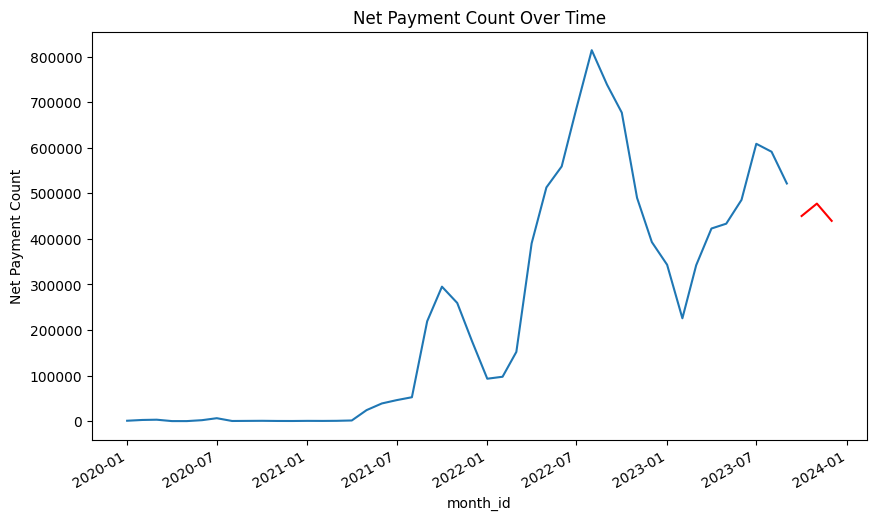

In [12]:
plot_payment_count_forecast(df, res, 'merchant_33179')

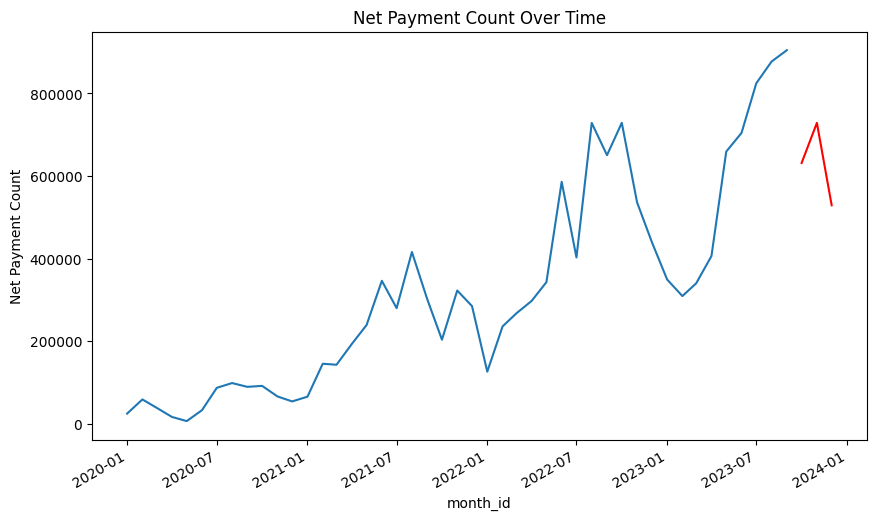

In [13]:
plot_payment_count_forecast(df, res, 'merchant_41628')

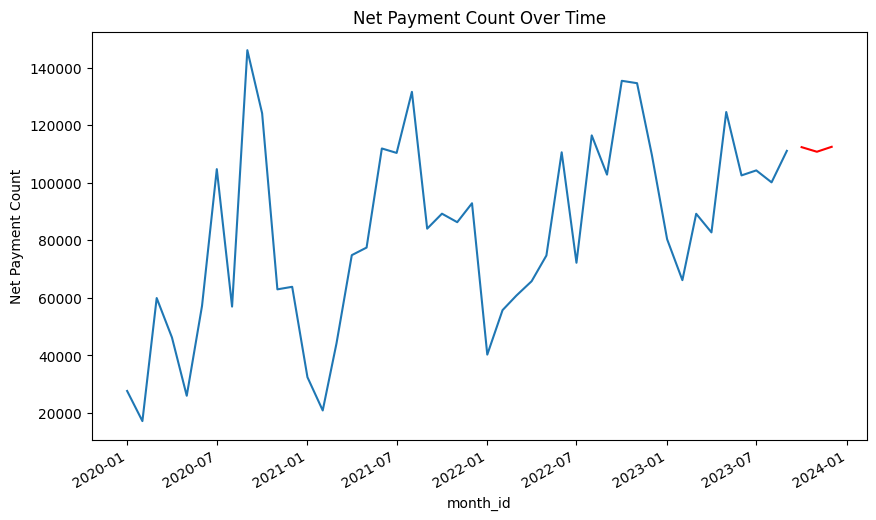

In [14]:
plot_payment_count_forecast(df, res, 'merchant_16119')